# Learning languages from a single message

[...] First we import everything that we're going to be using throughout the notebook.

In [1]:
import os
import sys
from inspect import cleandoc
from tqdm.notebook import tqdm

from statistics import median, mean
from itertools import combinations, product
from collections import defaultdict
from random import shuffle, sample, seed

import networkx as nx
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra

from algorithm.base import ShortestPathModel

from example.dataset_utils.sample_dataset import sample_dataset

import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('ggplot')

seed(42)

### Differentiating between English, French, Italian and German

For our first example, we're just going to take 5 languages (among 15 in our dataset) and see how well our algorithm works on differentiating messages of varying length in these languages. So let us first try it out on a simple example of a thousand messages from each of these languages, each 10 words long.

In [2]:
language_dict = {'en' : 'English',
                'fr': 'French',
                'it': 'Italian',
                'de': 'German',
                'fi': 'Finnish'}

Now we define the similarity score function. This function is the crux of this whole model, but it is very simple, owing to the fact that the domain is very simple. So, for two strings $s_1$ and $s_2$, we define 
$$
\operatorname{weight}(s_1, s_2, p)=
\begin{cases}
\text{(number of words shared by } s_1 \text{ and } s_2 \text{)}^{-p} & \text{ if } s_1 \text{ and } s_2 \text{ share at least one word,}\\
\infty & \text{ otherwise.}\\
\end{cases}
$$
Here $\infty$ is a shorthand for "there is no edge between those two vertices."

In [3]:
def weights(string1, string2, p=2):
    intersection = [x for x in string1 if x in string2]
    if len(intersection) == 0:
        return float('inf')
    else:
        return 1/(len(intersection) ** p)

Let's see how our model works on a very basic example. We'll draw $1000$ examples (of length $10$ words) from English and French and use one example from English to classify all the rest.

In [4]:
english = sample_dataset(n=1000,
                        length=10,
                        language='en')
french = sample_dataset(n=1000,
                        length=10,
                        language='fr')


model = ShortestPathModel(weight_fn=weights)
model.prepare_data(anchor_class=english,
                    other_class=french)
model.fit_predict()

print(f'Model\'s accuracy is {100*round(model.accuracy_, 4)}%.')

Model's accuracy is 99.1%.


Now we'll do a somewhat more extensive experiment. For each (unordered) pair of languages from the set {english, french, german, italian, finnish}, we're going to compute 25 different samples of 1000 messages of word length 10, and then compute and record each of their accuracies. Note that when we draw 1000 messages of lenght 10 we're drawing 10 thousands words, which is a small subset of the dataset which contains about 3 million words for each language, providing assurance that there will be little overlap between different samples. 

(The justification for using unordered pairs is that the results should, in aggregate, look pretty similar regardless of whatever we're using e.g. an English message to differentiate it from French, or a French message to differentiate it from English, for the 'structure' based on which they're learning is the same -- they're operating on the same graph, that is, so while local discrepancies are possible, globally the results should be pretty similar. But we shall later investigate a bit more deeply the nature of those 'local discrepancies'.)

We'll, of course, plot the results.

In [22]:
accuracies = defaultdict(list)

for language_anchor, language_other in tqdm(combinations(language_dict.keys(), r=2)):
    if language_anchor == language_other:
        continue
    for _ in range(3):
        anchor = sample_dataset(n=1000,
                        length=10,
                        language=language_anchor)
        other = sample_dataset(n=1000,
                        length=10,
                        language=language_other)
        model = ShortestPathModel(weight_fn=weights)
        model.prepare_data(anchor, other)    
        model.fit_predict()
    
        accuracies[(language_anchor, language_other)].append(model.accuracy_)

In [24]:
# just preparing the data for the matplotlib boxplot
# 1) ordering the language comparisons by mean
accuracies = {k: v for k, v in sorted(accuracies.items(), key=lambda item: mean(item[1]))}
# 2) making thee labels more readable
labels = [f'{language_dict[l]}/\n{language_dict[q]}' for l, q in accuracies.keys() ]

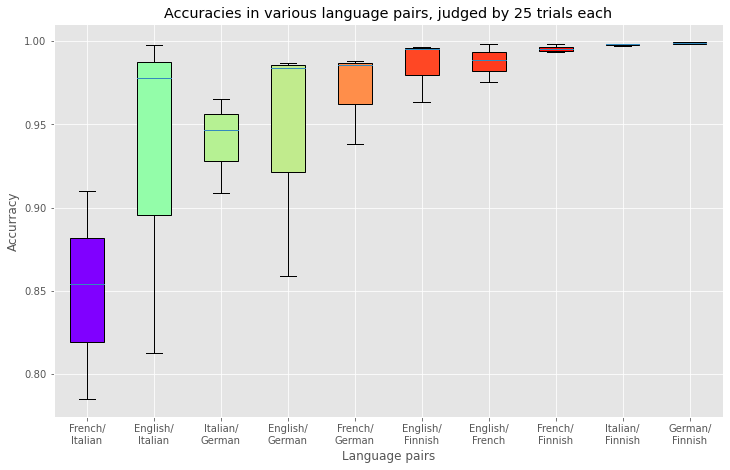

In [29]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=labels, patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in various language pairs, judged by 25 trials each")
ax.set_xlabel('Language pairs')
ax.set_ylabel('Accurracy')

plt.show()

As we can see, all the mean accuracies are above $95\%$ with the exception of French and Italian. This is not suprising, given that they have a very high [lexical similarity](https://en.wikipedia.org/wiki/Lexical_similarity#Indo-European_languages). For this reason we're going to drop all the other language pairs and focus exclusively on French and Italian from now on.

## Playing with hyperparameters

In the above example, we've seen that the model works well when given 1000 messages of length 10 in each language, and with the similarity function of inverse of the squared difference of the number of words shared. So there are a few things we can play with: the number of messages, their length, and the similarity function (in which, for simplicity, we'll only change the "squared" part).

### Vary the length of messages

Let's see how the algorithm depends on the length of messages. We'll try the following lengths: 2, 3, 5, 8, 10, 12, 15, 20, 25, 40, 80. For each of these we'll draw 20 samples and evaluate the accuracy on each of them, boxplotting the results again.

In [30]:
lengths = [2, 3, 5, 8, 10, 12,
            15, 20, 25, 40, 80]

num_of_draws = 20
accuracies = defaultdict(list)

for length in tqdm(lengths):
    for _ in range(num_of_draws):
        french = sample_dataset(n=1000, length=length, language='fr')
        italian = sample_dataset(n=1000, length=length, language='it')
        
        model = ShortestPathModel(weights)

        model.prepare_data(french, italian)    
        model.fit_predict()

        accuracies[length].append(model.accuracy_)

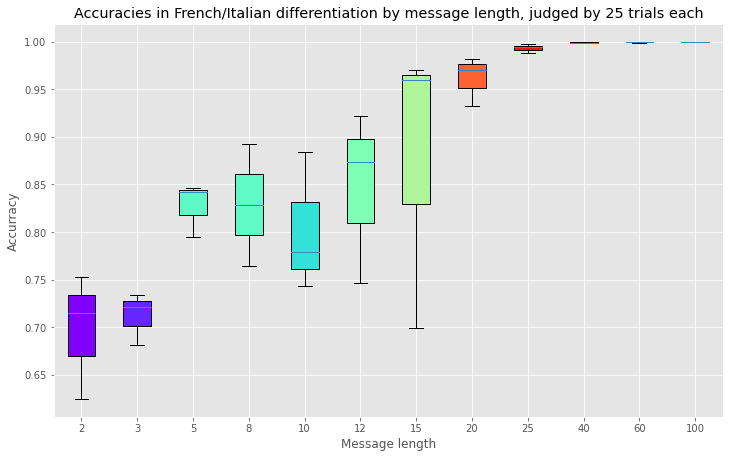

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=accuracies.keys(), patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in French/Italian differentiation by message length, judged by 20 trials each")
ax.set_xlabel('Message length')
ax.set_ylabel('Accurracy')

plt.show()

### How few/many is too few/many?

We'll take the parameter found to be the best in the above example, and try to vary the number of examples drawn. We'll experiment with sizes: 20, 30, 60, 100, 200, 500, 1000, 2000, 5000. Note that the memory requirement of the algorithm rises quadratically with the size of the sample -- this is because the number of edges in a complete graph is $n(n-1)/2$, hence the expected growth is something like $n/(n-1)/2$ multiplied by roughly the probability that two messages contain some overlap (i.e. that they are connected with an edge). Various other things in the algorithm also rise quadratically.

We'll also fix the length at 15 words per message, as we'd seen that with 1000 examples per class and that length the algorithm works reasonably well but well off from perfection, and thus it is interesting to see how the accuracy is going to vary with the number of examples.

In [35]:
sample_sizes = [20, 30, 60, 100, 200, 500, 1000, 1500, 2000]

num_of_draws = 5
accuracies = defaultdict(list)

for size in tqdm(sample_sizes):
    for _ in range(num_of_draws):
        french = sample_dataset(n=size, length=15, language='fr')
        italian = sample_dataset(n=size, length=15, language='it')
        
        model = ShortestPathModel(weights)

        model.prepare_data(french, italian)    
        model.fit_predict()

        accuracies[length].append(model.accuracy_)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=accuracies.keys(), patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in French/Italian differentiation by message length, judged by 20 trials each")
ax.set_xlabel('Message length')
ax.set_ylabel('Accurracy')

plt.show()

### Weighing on important things

As we had said earlier in this notebook, the crucial part of this model is the weight function. The weight function, quite literally, makes or breaks the model (if the weight function is such that the graph is not connected the algorithm cannot go through, if it is such that everything is connected then you might as well not build a graph).

We're going to make only smallish experiments with the weight function, in particular we're going to change the factor $p$ by which the number of words shared between examples if potentiated. In intuitive sense, if $p$ is small (near $0$) then we expect not making a big difference whether the messages share say 1 or 3 words, whereas high $p$ means it makes a lot of difference.

We're going to try out the following values for p: 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3.5, 5.

We're going to be fixing the length parameter at ... and the sample size parameter at ...

In [1]:
p_vals = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3.5, 5]
num_of_draws = 20

for p in tqdm(p_vals):
    for _ in range(num_of_draws):
        french = sample_dataset(n=size, length=whatever, language='fr')
        italian = sample_dataset(n=size, length=whatever, language='it')
        
        model = ShortestPathModel(lambda x: weights(x, p=p))

        model.prepare_data(french, italian)    
        model.fit_predict()

        accuracies[length].add(model.accuracy_)

## Wrapping it up

In all of the experiments we tried, we varied one parameter while leaving others fixed. This is of course not the full investigation of the nature of hyperparameters that one might wish for, but grasping the full interrelations of hyperparameters is somewhat out of scope of this notebook – one would have to conduct experiments on more datasets, with stricter sampling procedure, etc.

But let us still conclude what we can, from what we've done: first off, the algorithm, in a sense, _works_. It separates the two classes pretty well, though in most cases with the accuracy below $100\%$. 